# Verursacht Temu eine Erhöhung von Frachtflüfgen von China nach Europa? (Zweiter Datensatz)

Max Köhler/SWR DataLab (max.koehler@swr.de), 22. Oktober 2024 (Aktualisiert 31. Oktober 2024)

## 1. Analyse


In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from os import listdir
from os.path import isfile, join

In [2]:
# Proprietary flight data
file_dirs = ["./data/china-germany", "./data/china-belgium", "./data/china-netherlands"]
flights = pd.DataFrame()
for fd in file_dirs:
	filenames = [f for f in listdir(fd) if isfile(join(fd, f))]
	print(f"Reading {fd}: {len(filenames)} data files found")
	for fn in filenames:
		path = f"{fd}/{fn}"
		flights = pd.concat([flights, pd.read_csv(path, parse_dates=["date"], dtype={"flight_id": str})])


# Public domain airport data (https://ourairports.com/data/)
airports = pd.read_csv("./data/airports.csv")

Reading ./data/china-germany: 1 data files found
Reading ./data/china-belgium: 94 data files found
Reading ./data/china-netherlands: 94 data files found


In [3]:
# Drop airports without IATA codes
airports = airports.drop(
    airports[
        (airports["iata_code"].isnull())
     	| (airports["iata_code"] == "nan")
  	].index)

# Select takeoff events with destination IATA Codes
takeoffs = flights[
			(flights["destination_iata"].notnull())
    & (flights["event"] == "takeoff")
        ].drop_duplicates().reset_index(drop=True)

takeoffs["year_week"] = takeoffs["date"].apply(lambda x: f"{x.isocalendar()[0]}-{x.isocalendar()[1]}")
takeoffs["year_day"] = takeoffs["date"].dt.dayofyear

print(f"{takeoffs.shape[0]} takeoffs found.")

610506 takeoffs found.


In [4]:
# Merge airports on destination_iata
merged_flights = pd.merge(
	takeoffs,
	airports[["iata_code", "iso_country"]],
	how="left",
	left_on=["destination_iata"],
	right_on="iata_code").drop("iata_code", axis=1)

merged_flights["destination_country"] = merged_flights["iso_country"]
merged_flights.drop("iso_country", axis=1, inplace=True)

# Merge airports on origin_iata
merged_flights = pd.merge(
	merged_flights,
	airports[["iata_code", "iso_country"]],
	how="left",
	left_on=["origin_iata"],
	right_on="iata_code").drop("iata_code", axis=1)

merged_flights["origin_country"] = merged_flights["iso_country"]
merged_flights.drop("iso_country", axis=1, inplace=True)

missed_destination = merged_flights.loc[merged_flights["destination_country"].isnull()].shape[0]
missed_origin = merged_flights.loc[merged_flights["origin_country"].isnull()].shape[0]

print(f'Failed to set origin country for {missed_origin} flights ({round(missed_origin / takeoffs.shape[0] * 100, 2)}%) and destination country for {missed_destination} flights ({round(missed_destination / takeoffs.shape[0] * 100, 2)}%),\nlikely because their IATA codes are missing from our airport data.')

Failed to set origin country for 2922 flights (0.48%) and destination country for 1026 flights (0.17%),
likely because their IATA codes are missing from our airport data.


In [5]:
# Define origin and destination countries we're interested in
eu_countries = ("DE", "BE", "NL")
origin_countries = ("CN", "HK")

# Flights from any Chinese or Hong Kong airport that landed in any Belgian, German, or Dutch airport
flights_china_eu = merged_flights.loc[
    (merged_flights["origin_country"].isin(origin_countries))
    & (merged_flights["destination_country"].isin(eu_countries))]

print(f"{flights_china_eu.shape[0]} flights from {origin_countries} to {eu_countries} found.")

11224 flights from ('CN', 'HK') to ('DE', 'BE', 'NL') found.


## 2. Ergebnisse

### 2.1 Welche Daten liegen vor?

Die 189 vorliegenden CSV-Dateien enthalten Daten für weltweite, von FlightRadar24 erfasste Flüge im Zeitraum 01.01.2023-2024. Jeder Flug ist in einer Zeile repräsentiert einen Flug (es gibt Duplikate, aber diese werden in dieser Analyse bereits herausgefiltert). Insgesamt wurden 610.506 Flüge erfasst. Wir verschränken diese Daten mit einem freien Datensatz zu Flughäfen von [OurAirports](https://davidmegginson.github.io/ourairports-data/). Das erlaubt es uns, die Flughafen-Codes bestimmten Ländern zuzuordnen und Meta-Daten wie Namen, Koordinaten usw. auszugeben.

Zu jedem Flug werden eine Reihe von mehr oder weniger interessanten Metadaten angegeben. Die Spalte `event` enthält die Art des erfassten Flgereignisse. Anders als der erste Datensatz enthält vorliegende nur Ereignisse vom Typ `takeoff`. Die Spalten `origin_iata` und `destination_iata` sind Flughafen-Codes. Lufthansa Cargo LH8403 von Shanghai Pudong International (`PVG`) nach Frankfurt (`FRA`) am 01.02.2023 ist zum Beispiel so repräsentiert:


In [6]:
merged_flights.loc[merged_flights["flight_id"] == "783802017"]

,address,altitude,callsign,date,destination_iata,destination_icao,equipment,event,flight,flight_id,...,longitude,operator,origin_iata,origin_icao,registration,time,year_week,year_day,destination_country,origin_country
489,7805DC,4300,CKK211,2023-01-02,FRA,EDDF,B77L,takeoff,CK211,783802017,...,121.82915,CKK,PVG,ZSPD,B-2076,03:33:28,2023-1,2,DE,CN


### 2.2 Kann man an den Daten erhöhten Flugverkehr durch Temu erkennen?

**Nein**. Aus der letzten Analyse wurde ersichtlich, dass "zwischen dem Start von Temu in 2023 und 2024 die Zahl der Flüge von China nach Europa um 36.3% gestiegen" ist. Mehr kann man aus den vorliegenden Daten auch nicht ablesen. Das Flugaufkommen fluktuiert, ein _Temu Spike_ ist nicht zu erkennen.


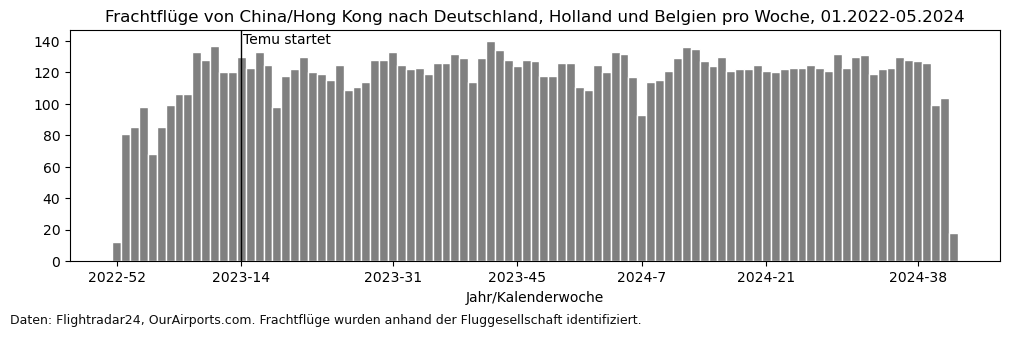

In [7]:
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

flights_per_period = pd.DataFrame(data=flights_china_eu.groupby(flights_china_eu.year_week).size(), columns=["count"]).reset_index()

# Some wrangling to bring the weekly counts back to chronological order
flights_per_period["year"] = flights_per_period["year_week"].str.split("-").apply(lambda x: int(x[0]))
flights_per_period["week"] = flights_per_period["year_week"].str.split("-").apply(lambda x: int(x[1]))
flights_per_period.sort_values(inplace=True,by=["year", "week"])

labels = pd.DataFrame([
	{"date": "2023-14", "text": "Temu startet", "y_offset": 0, "source": "https://www.reuters.com/technology/chinese-owned-e-commerce-platform-temu-expands-europe-2023-04-25/"},
])

fig,ax = plt.subplots(figsize=(12,3))
ax.set_title("Frachtflüge von China/Hong Kong nach Deutschland, Holland und Belgien pro Woche, 01.2022-05.2024")
ax.bar(
  x=flights_per_period["year_week"],
  height=flights_per_period["count"],
	label="Anzahl Flüge",
	color="gray",
	width=1,
	edgecolor="white"
)
ax.xaxis.set_major_locator(locator)
ax.set_xlabel("Jahr/Kalenderwoche")
plt.xticks(rotation=0)
for index, l in labels.iterrows():
	ax.axvline(x=l["date"], color="black", lw=1, zorder=10)
	ax.annotate(
		zorder=200,
		text=l["text"],
		xy=(l["date"], 0),
		horizontalalignment="left",
		textcoords=("offset fontsize","axes fraction"),
		xytext=(.15,.94)
	)

ax.text(x=0.075, y=-0.1, s="Daten: Flightradar24, OurAirports.com. Frachtflüge wurden anhand der Fluggesellschaft identifiziert.", transform=fig.transFigure, ha='left', fontsize=9, alpha=.95, linespacing=1.35)
plt.show()


### 2.3 Welche Verbindungen gab es zwischen China/Hong Kong - und Deutschland/Holland/Belgien in 2024?

2024 wurden insgesamt **30** verschiedene Verbindungen zwischen China/Hong Kong und Deutschland/Belgien/Holland geflogen.


In [8]:
connections = merged_flights.loc[
    (merged_flights["origin_country"].isin(origin_countries))
    & (merged_flights["destination_country"].isin(eu_countries))
    & (merged_flights["date"].dt.year == 2024)].groupby(["origin_iata", "destination_iata"]).size().reset_index().rename(columns={0: "count"})

connections["origin_airport"] = connections["origin_iata"].apply(lambda x: airports.loc[airports["iata_code"] == x]["name"].values[0])
connections["origin_lat"] = connections["origin_iata"].apply(lambda x: airports.loc[airports["iata_code"] == x]["latitude_deg"].values[0])
connections["origin_long"] = connections["origin_iata"].apply(lambda x: airports.loc[airports["iata_code"] == x]["longitude_deg"].values[0])

connections["destination_lat"] = connections["destination_iata"].apply(lambda x: airports.loc[airports["iata_code"] == x]["latitude_deg"].values[0])
connections["destination_long"] = connections["destination_iata"].apply(lambda x: airports.loc[airports["iata_code"] == x]["longitude_deg"].values[0])
connections["destination_airport"] = connections["destination_iata"].apply(lambda x: airports.loc[airports["iata_code"] == x]["name"].values[0])

print(f"{len(connections)} connections found.")
connections[["origin_airport", "origin_iata", "origin_lat", "origin_long", "destination_airport", "destination_iata","destination_lat", "destination_long", "count"]]

30 connections found.


,origin_airport,origin_iata,origin_lat,origin_long,destination_airport,destination_iata,destination_lat,destination_long,count
0,Guangzhou Baiyun International Airport,CAN,23.392401,113.299004,Amsterdam Airport Schiphol,AMS,52.308601,4.763890,148
1,Guangzhou Baiyun International Airport,CAN,23.392401,113.299004,Cologne Bonn Airport,CGN,50.865898,7.142740,195
2,Guangzhou Baiyun International Airport,CAN,23.392401,113.299004,Frankfurt Airport,FRA,50.030241,8.561096,80
3,Guangzhou Baiyun International Airport,CAN,23.392401,113.299004,Liège Airport,LGG,50.638574,5.443897,123
4,Zhengzhou Xinzheng International Airport,CGO,34.526497,113.849165,Frankfurt Airport,FRA,50.030241,8.561096,33
5,Zhengzhou Xinzheng International Airport,CGO,34.526497,113.849165,Liège Airport,LGG,50.638574,5.443897,173
6,Chongqing Jiangbei International Airport,CKG,29.712254,106.651895,Amsterdam Airport Schiphol,AMS,52.308601,4.763890,115
7,Chongqing Jiangbei International Airport,CKG,29.712254,106.651895,Frankfurt Airport,FRA,50.030241,8.561096,19
8,Chengdu Shuangliu International Airport,CTU,30.558257,103.945966,Amsterdam Airport Schiphol,AMS,52.308601,4.763890,85
9,Chengdu Shuangliu International Airport,CTU,30.558257,103.945966,Brussels Airport,BRU,50.901402,4.484440,21


### 2.4 Gab es 2024 Verbindungen von China nach Europa, die es 2023 noch nicht gab?

**Ja**, es gab 2024 Verbindungen, die es 2023 noch nicht gab. Allerdings sind 2024 auch einige Verbindungen weggefallen, sodass die Zahl der verschiedenen Verbindungen insgesamt von 31 auf 30 abnahm.


In [9]:
merged_flights["connection"] = merged_flights["origin_iata"].astype(str) + "-"  + merged_flights["destination_iata"].astype(str)

connections_23 = merged_flights.loc[
    (merged_flights["origin_country"].isin(origin_countries))
    & (merged_flights["destination_country"].isin(eu_countries))
    & (merged_flights["date"].dt.year == 2023)]["connection"]

connections_24 = merged_flights.loc[
    (merged_flights["origin_country"].isin(origin_countries))
    & (merged_flights["destination_country"].isin(eu_countries))
    & (merged_flights["date"].dt.year == 2024)]["connection"]

l1 = pd.Series(sorted(pd.unique(connections_23)))
l2 = pd.Series(sorted(pd.unique(connections_24)))

print(f"{len(l1)} connections found in 2023, {len(l2)} in 2024.")
print("Connections added in 2024:")
print(l2[~l2.isin(l1)])

print("Connections dropped in 2024:")
print(l1[~l1.isin(l2)])

31 connections found in 2023, 30 in 2024.
Connections added in 2024:
14    HKG-BRU
28    TFU-BRU
29    TFU-FRA
dtype: object
Connections dropped in 2024:
13    HGH-AMS
20    NTG-LEJ
29    TAO-LGG
30    XMN-LGG
dtype: object


### 2.5 Welche Flüge gab es in Lüttich am 24. Januar 2024?

Unsere Daten enthalten nur _takeoffs_, deshalb entsprechen die `time`, `date`, und Reihenfolge der Flüge nicht dem, was wir am Boden beobachtet haben. Für den 24. Januar finden wir in unserem Datensatz 7 Flüge.


In [10]:
merged_flights.loc[
    (merged_flights["destination_iata"] == "LGG")
    & (merged_flights["origin_country"].isin(origin_countries))
    & (merged_flights["date"].isin(["2024-01-23"])) # We query the day before the one we're interested in because the flight takes 7 hours.
]

,address,altitude,callsign,date,destination_iata,destination_icao,equipment,event,flight,flight_id,...,operator,origin_iata,origin_icao,registration,time,year_week,year_day,destination_country,origin_country,connection
301119,04008D,1750,ETH3759,2024-01-23,LGG,EBLG,B77L,takeoff,ET3759,867715527,...,ETH,SZX,ZGSZ,ET-ARK,07:46:48,2024-4,23,BE,CN,SZX-LGG
301169,04008C,3950,ETH3751,2024-01-23,LGG,EBLG,B77L,takeoff,ET3751,867730897,...,ETH,CAN,ZGGG,ET-ARJ,10:14:01,2024-4,23,BE,CN,CAN-LGG
301498,040168,3825,ETH3681,2024-01-23,LGG,EBLG,B77L,takeoff,ET3681,867816757,...,ETH,CGO,ZHCC,ET-AWE,19:47:44,2024-4,23,BE,CN,CGO-LGG
301555,AC1E56,3100,FDX5170,2024-01-23,LGG,EBLG,B77L,takeoff,FX5170,867822696,...,FDX,PVG,ZSPD,N880FD,21:19:42,2024-4,23,BE,CN,PVG-LGG
301706,04022A,2900,ETH3779,2024-01-23,LGG,EBLG,B77L,takeoff,ET3779,867836576,...,ETH,PVG,ZSPD,ET-BAA,22:22:41,2024-4,23,BE,CN,PVG-LGG
558822,ABF0C7,150,FDX5021,2024-01-23,LGG,EBLG,B77L,takeoff,FX5021,867828975,...,FDX,HKG,VHHH,N869FD,23:03:29,2024-4,23,BE,HK,HKG-LGG
558840,040060,25,ETH3034,2024-01-23,LGG,EBLG,B77L,takeoff,ET3034,867838934,...,ETH,HKG,VHHH,ET-APS,22:38:35,2024-4,23,BE,HK,HKG-LGG


### 2.6 Wie hat sich die Zahl von Frachtflügen/Woche an den angegebenen Flughäfen zwischen 2023 und 2024 verändert?

- Die Zahl von Frachtflügen ist insgesamt um 4,91% gestiegen, von durchschnittlich 114,38 Frachtflüge/Woche auf 120,0 Frachtflüge/Woche
- Den stärksten Anstieg gab es in In Liège: 23,1 Frachtflüge/Woche in 2023 auf 28,3 Frachtflüge/Woche in 2024, ein Anstieg von 22,37%.
- Im Regionalflughafen Liège landen fast so viele Frachtflüge landen wie in Amsterdam und Frankfurt.
- In Leipzig ist die Zahl der Frachtflüge 16,24% gestiegen
- In Frankfurt, Amsterdam, Brüssel und Köln ist die Zahl der Frachtflüge gefallen.

Weil noch nicht alle Daten für 2024 vorliegen wurden für beide Jahre nur die ersten 288 Tage berücksichtigt.


In [14]:
# Pull 2024 flights
china_eu_24 = merged_flights.loc[
    (merged_flights["origin_country"].isin(origin_countries))
    & (merged_flights["destination_country"].isin(eu_countries))
    & (merged_flights["date"].dt.year == 2024)]

# Pull 2023 up to the date where our 2024 data ends
cutoff = china_eu_24["year_day"].max()
china_eu_23 = merged_flights.loc[
    (merged_flights["origin_country"].isin(origin_countries))
    & (merged_flights["destination_country"].isin(eu_countries))
    & (merged_flights["date"].dt.year == 2023)
    & (merged_flights["year_day"] <= cutoff)]

years = [2023,2024]
destination_iatas = pd.unique(china_eu_23["destination_iata"])
results = pd.DataFrame(columns=["iata", "name"])

# Calculate flights/per week per European airport
for iata in destination_iatas:
	result = pd.DataFrame({"iata": [iata], "name": airports.loc[airports["iata_code"] == iata]["name"].values})
	for y in years:
		flights_year = merged_flights.loc[
			(merged_flights["origin_country"].isin(origin_countries))
    	& (merged_flights["destination_iata"] == iata)
    	& (merged_flights["date"].dt.year == y)
    	& (merged_flights["year_day"] <= cutoff)
		]
		fpw = pd.DataFrame(data=flights_year.groupby(flights_year.year_week).size(), columns=["count"]).reset_index()
		result[f"fpw_{y}"] = fpw["count"].mean()
	results = pd.concat([results, result], ignore_index=True)


# Calculate flights/per week across all EU airports
fpw_23 = pd.DataFrame(data=china_eu_23.groupby(china_eu_23.year_week).size(), columns=["count"]).reset_index()
fpw_24 = pd.DataFrame(data=china_eu_24.groupby(china_eu_24.year_week).size(), columns=["count"]).reset_index()
totals = pd.DataFrame({
	"name": [f"All Airports in {eu_countries}"],
	"fpw_2023": [fpw_23["count"].mean()],
	"fpw_2024": [fpw_24["count"].mean()]
	})

results = pd.concat([results, totals], ignore_index=True)
results["change"] = results["fpw_2024"].divide(results["fpw_2023"]) - 1

print(f"Cutoff day: {cutoff}")
pd.DataFrame(results)

Cutoff day: 288


,iata,name,fpw_2023,fpw_2024,change
0,LGG,Liège Airport,23.095238,28.261905,0.223711
1,AMS,Amsterdam Airport Schiphol,30.904762,30.476190,-0.013867
2,FRA,Frankfurt Airport,31.690476,30.547619,-0.036063
3,LEJ,Leipzig/Halle Airport,21.404762,24.880952,0.162403
4,CGN,Cologne Bonn Airport,6.547619,5.285714,-0.192727
5,BRU,Brussels Airport,3.100000,2.300000,-0.258065
6,NaN,"All Airports in ('DE', 'BE', 'NL')",114.380952,120.000000,0.049126
